# Ground Penetrating Radar

## Attenuation Analysis

The complex wavenumber $k$ is given as
\begin{align}
k &= \beta + i \alpha
\end{align}
where $\alpha$ is the attenuation constant (Np/m) and $\beta$ is the phase constant (rad/m):
\begin{align}
\alpha &= \omega \sqrt{\epsilon \mu} \Big[\frac{1}{2} \Big(\sqrt{1 + \Big (\frac{\sigma}{\epsilon \omega}\Big )^2} - 1 \Big) \Big]^2 \\
\beta &= \omega \sqrt{\epsilon \mu} \Big[\frac{1}{2} \Big(\sqrt{1 + \Big (\frac{\sigma}{\epsilon \omega}\Big )^2} + 1 \Big) \Big]^2
\end{align}

where 
\begin{align}
\omega &= 2 \pi f \qquad \\
\epsilon &= \epsilon_r \epsilon_0 \\
\mu &= \mu_r \mu_0
\end{align}
and $f$ is the center frequency, $\sigma$ is the electrical conductivity, $\epsilon_0 = 8.85 \times 10^{-12}$, $\mu_0 = 4 \pi \times 10^{-7}$.

Note that the wavelength $\lambda$ and velocity $v$ are 
\begin{align}
\lambda &= \frac{2 \pi}{\beta} \\
v &= \lambda f = \frac{\omega}{\beta}
\end{align}

We can also express the attenuation constant in dB as $\alpha_{dB} = \alpha \cdot 20 \log_{10}(e) \approx 8.686 \cdot \alpha$

Noting that $\epsilon$ and $\mu$ are generally complex and a function of frequency, they can be expressed as
\begin{align}
\epsilon(\omega) &= \epsilon'(\omega) - j \epsilon''(\omega) \\
\sigma &= \sigma' + j \sigma ''
\end{align}

The equations above can be put in terms of the real permittivity and real conductivity
\begin{align}
\epsilon_e &= \epsilon' - \frac{\sigma''}{\omega} \\
\sigma_e &= \sigma' + \epsilon ''\omega
\end{align}

Typically for radar, $\sigma' = \sigma_{DC}$ (the DC conductivity) and $\sigma''=0$.

### Low loss approximation
If $\sigma_e << \epsilon_e \omega$ then
\begin{align}
\alpha & \approx \frac{\sigma_e}{2}\sqrt{\frac{\mu}{\epsilon_e}}
\end{align}
We note that environments where GPR is is effective generally satisfy this requirement.

For real materials, however, permittivity is complex and frequency dependent. Thus
\begin{align}
\alpha & \approx \frac{\sigma_{DC} + \epsilon''(\omega) \omega}{2}\sqrt{\frac{\mu}{\epsilon'(\omega)}}
\end{align}

### Cole-Cole relaxation
For most earth materials, the complex dielectric permittivity is described as
\begin{align}
\epsilon(\omega) &= \epsilon(\omega)'-j\epsilon''(\omega) = \epsilon_{\infty} + \frac{\epsilon_{DC} - \epsilon_{\infty}}{1+(j\omega \tau)^{\gamma}}
\end{align}

where $\tau$ is the relaxation time and $\gamma$ is the fit parameter.

### Earth Materials

|Layer | $\epsilon_{DC}$/$\epsilon_0$| $\epsilon_{\infty}$/$\epsilon_0$ | $\tau$ (ns) | $\gamma$ | $\sigma_{DC}$ (mS/m) |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| Dry sand | 5.7 | 3.4 | 8.0 | .70 | .45 |
| Moist sand | 8.9 | 5.6 | 11.0 | .75 | 2.00 |
| Wet sand | 29.0 | 25.6 | 22.2 | .88 | 6.06 |
| Clay (30% water) | 43.0 | 20.7 | 18.3 | .66 | 42.5 |


## Matlab/Octave Model
## Attenuation vs frequency

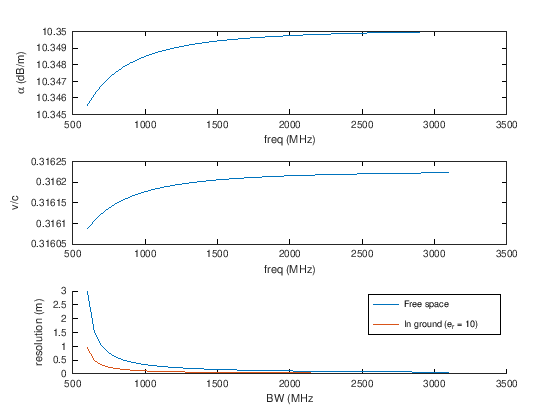

In [8]:
sig = 2e-2;
bws = 50e6;
fc = 600e6:50e6:3100e6;
bw = fc-fc(1)+bws;
er = 10;

mu0 = 4*pi*1e-7;
e0 = 8.85e-12;
c = 1./sqrt(mu0*e0);

eps = er*e0;
mu = 1*mu0;

w = 2*pi*fc;

a = w.*sqrt(mu*eps).*(.5*(sqrt(1+(sig./(w.*eps)).^2)-1)).^.5;
v = sqrt(1/(mu*eps))*(.5*(sqrt(1+(sig./(w.*eps)).^2)+1)).^(-.5);

a_db = a*20*log10(exp(1));

figure; 
subplot(3,1,1);plot(fc./1e6,a_db); xlabel('freq (MHz)'); ylabel('\alpha (dB/m)');
subplot(3,1,2);plot(fc./1e6,v./c); xlabel('freq (MHz)'); ylabel('v/c');
subplot(3,1,3); hold on;
plot(fc./1e6,c./(2*bw));
plot(fc./1e6,v./(2*bw));
legend('Free space',sprintf('In ground (e_r = %g)',er)); xlabel('BW (MHz'); ylabel('resolution (m)');

### Simulate effects on UWB LFM waveform

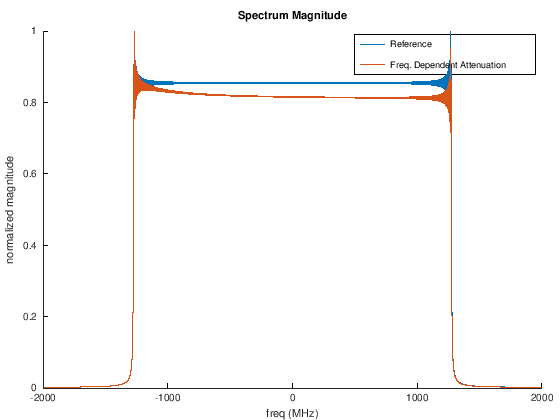

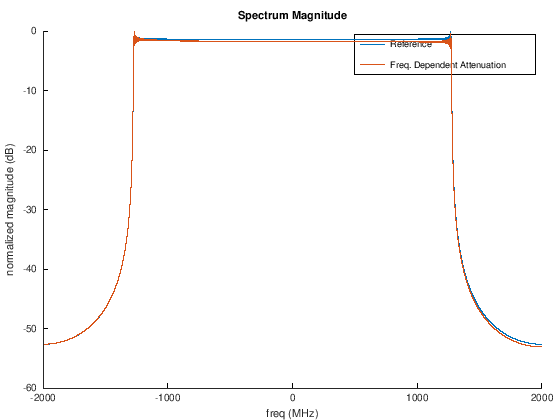

In [11]:
fs = 4e9;
N = 4096*numel(fc);
n = [0:(N-1)]-N/2;
bw1 = bw(end);
t = n./fs;

s = exp(1i*pi*.5*(bw1/t(end))*t.^2);
s_fft = fftshift(fft(s));
freq = n.*(fs/N);
[~,imin]=min(abs(freq+bw1/2));
[~,imax]=min(abs(freq-bw1/2));

depth = 100; %m;
atten_db = depth*a_db;
atten_db = interp1(fc,atten_db,linspace(fc(1),fc(end),numel(s_fft(imin:imax))));
atten_db1 = zeros(1,numel(s_fft));
atten_db1(imin:imax)=atten_db;
atten_db1(1:imin)=atten_db(1);
atten_db1(imax:end)=atten_db(end);
atten_db = atten_db1;

r_fft = s_fft./(10.^(.05*atten_db));

figure; hold on;
plot(freq/1e6,20*log10(abs(s_fft)./max(abs(s_fft))));
plot(freq/1e6,20*log10(abs(r_fft)./max(abs(r_fft))));
xlabel('freq (MHz)'); ylabel('normalized magnitude (dB)'); title('Spectrum Magnitude');
legend('Reference','Freq. Dependent Attenuation');

figure; hold on;
plot(freq/1e6,(abs(s_fft)./max(abs(s_fft))));
plot(freq/1e6,(abs(r_fft)./max(abs(r_fft))));
xlabel('freq (MHz)'); ylabel('normalized magnitude'); title('Spectrum Magnitude');
legend('Reference','Freq. Dependent Attenuation');

r = ifft(ifftshift(r_fft));

% [d0,l0] = mfiltu(s,s,10);
% [d,l] = mfiltu(r,s,10);
% d0 = 20*log10(abs(d0));
% d0 = d0-max(d0);
% d = 20*log10(abs(d));
% d = d-max(d);

% figure; hold on; 
% plot(c*l0/(10*fs*2),d0);
% plot(c*l/(10*fs*2),d);
% axis([-10,10,-70,4]);

### References

John H. Bradford. [Frequency-Dependent Attenuation Analysis of Ground-Penetrating Radar Data](https://scholarworks.boisestate.edu/cgi/viewcontent.cgi?article=1037&context=cgiss_facpubs). 2007